In [1]:
import json, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

from scipy import stats

import pytz 

from datetime import timedelta, datetime

from research.utils.data_access_utils import RDSAccessUtils

In [2]:
rds_access_utils = RDSAccessUtils(json.load(open(os.environ['PROD_SQL_CREDENTIALS'])))

In [3]:
queryCache = {}

In [4]:
df_start_date = '2020-11-01'
df_end_date = '2020-11-30'

query = """
    select *
    from day_summaries ds
    where ds.date >= '%s'
    and ds.date <= '%s';
""" % (df_start_date, df_end_date)

if query in queryCache:
    df = queryCache[query]
else:
    df = rds_access_utils.extract_from_database(query)

    queryCache[query] = df
    
df.index = df['date']

df = df.sort_index()

In [5]:
num_fish = []
counts = []
pen_ids = []

for index, row in df.iterrows():
#     numFish = row['lice_data']['rawData']['numFish']
    count = row['lice_data']['rawData']['numPartialAndFullFish']
    
    if count > 0:
        pen_ids.append(row['pen_id'])

#     num_fish.append(numFish)
    counts.append(count)
    
# df['numFish'] = num_fish    
df['numPartialAndFullFish'] = counts

In [6]:
pen_ids = list(set(pen_ids))

In [7]:
pen_ids

[1,
 132,
 4,
 5,
 137,
 138,
 140,
 142,
 144,
 145,
 149,
 159,
 163,
 171,
 173,
 186,
 187,
 188,
 193,
 67,
 201,
 207,
 208,
 210,
 211,
 85,
 86,
 113,
 114,
 122,
 123]

In [8]:
# pcts = []

total = []
num = []

for pen_id in pen_ids:
    df2 = df[df.pen_id == pen_id]
    rolling = df2[['numPartialAndFullFish']].rolling(5).sum()
    
    total.append(np.sum(rolling >= 100))
    num.append(np.sum(rolling > 0))
    
#     if pct.values[0] < 0.01:
#         print(pen_id)
#     pcts.append(pct.values[0])
    
# pcts

In [9]:
# df2 = df[df.pen_id == 149]
# df2.iloc[0]['lice_data']
for i, total_ in enumerate(total):
    print(pen_ids[i], total_.values[0], num[i].values[0])

1 26 26
132 4 5
4 23 26
5 26 26
137 9 10
138 12 16
140 26 26
142 26 26
144 26 26
145 26 26
149 0 7
159 0 1
163 26 26
171 20 22
173 20 23
186 0 0
187 17 20
188 0 1
193 26 26
67 26 26
201 20 20
207 5 6
208 4 5
210 2 4
211 3 4
85 23 24
86 26 26
113 3 5
114 18 19
122 17 26
123 26 26


In [10]:
np.sum(total) / np.sum(num)

0.9169811320754717

In [11]:
pen_id = 201
df_start_date = '2020-11-01'
df_end_date = '2020-11-25'

query = """
    select captured_at, annotation_metadata, annotated_by_email
    from annotations a
    where a.pen_id = %i
    and a.is_qa = true
    and a.is_skipped = false
    and a.captured_at > '%s'
    and a.captured_at < '%s';
""" % (pen_id, df_start_date, df_end_date)

if query in queryCache:
    df = queryCache[query]
else:
    df = rds_access_utils.extract_from_database(query)

    queryCache[query] = df
    
df.index = df['captured_at']

df['date'] = df.captured_at.dt.date

df = df.sort_index()

for index, lice_count in df.iterrows():
    liceCounts = lice_count['annotation_metadata']['liceCounts']

    df.loc[index, 'movingCountAdjusted'] = liceCounts['movingCountAdjusted']
    df.loc[index, 'adultFemaleCountAdjusted'] = liceCounts['adultFemaleCountAdjusted']
    df.loc[index, 'count'] = 1


In [12]:
list(set(df['date']))

[datetime.date(2020, 11, 14),
 datetime.date(2020, 11, 11),
 datetime.date(2020, 11, 16),
 datetime.date(2020, 11, 13),
 datetime.date(2020, 11, 18),
 datetime.date(2020, 11, 19),
 datetime.date(2020, 11, 21),
 datetime.date(2020, 11, 24),
 datetime.date(2020, 11, 12),
 datetime.date(2020, 11, 17),
 datetime.date(2020, 11, 20),
 datetime.date(2020, 11, 15)]

Text(0.5, 1.0, 'Number of Fish Counted vs Mobile Count')

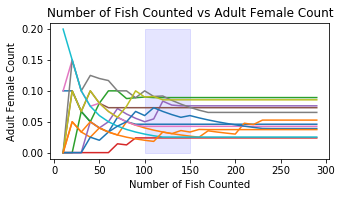

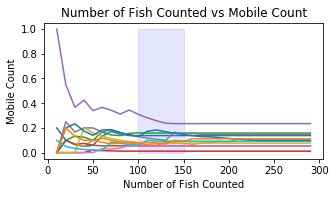

In [13]:
min_counts = np.arange(0, 300, 10)
dates = list(set(df['date']))
date_results_a = []
date_results_m = []

max_a = 0
max_m = 0

for date in dates:
    results_a = []
    results_m = []
    
    for min_count in min_counts:
        df2 = df[df.date == date].iloc[0:min_count]
        results_a.append(np.mean(df2['adultFemaleCountAdjusted']))
        results_m.append(np.mean(df2['movingCountAdjusted']))
        
        max_a = max(max_a, np.mean(df2['adultFemaleCountAdjusted']))
        max_m = max(max_m, np.mean(df2['movingCountAdjusted']))
    
    date_results_a.append(results_a)
    date_results_m.append(results_m)
    
plt.figure(figsize=(5, 2.5))

for results_a in date_results_a:
    plt.plot(min_counts, results_a)
    
plt.fill_between(min_counts, 0, max_a, where = (min_counts >= 100) & (min_counts <= 150), color = 'blue', alpha = 0.1)

plt.xlabel('Number of Fish Counted')
plt.ylabel('Adult Female Count')
plt.title('Number of Fish Counted vs Adult Female Count')

plt.figure(figsize=(5, 2.5))

for results_m in date_results_m:
    plt.plot(min_counts, results_m)
    
plt.fill_between(min_counts, 0, max_m, where = (min_counts >= 100) & (min_counts <= 150), color = 'blue', alpha = 0.1)

plt.xlabel('Number of Fish Counted')
plt.ylabel('Mobile Count')
plt.title('Number of Fish Counted vs Mobile Count')

In [14]:
cogito_lice_counts.ix[0]['annotation_metadata']

NameError: name 'cogito_lice_counts' is not defined

In [15]:
masks = {
    'eirik@aquabyte.ai': {},
    'embla@aquabyte.ai': {},
    'gunnar@aquabyte.ai': {},
    'orjan@aquabyte.ai': {},
    'labeler1@cogitotech.com': {},
    'labeler2@cogitotech.com': {},
    'labeler3@cogitotech.com': {},
    'labeler4@cogitotech.com': {},
    'labeler5@cogitotech.com': {}
}

columns = [ 'movingCountAdjusted', 'adultFemaleCountAdjusted' ]

for key, value in masks.items():
    masks[key]['cogito_daily'] = cogito_lice_counts[cogito_lice_counts['annotated_by_email'] == key][columns].rolling('%iD' % (1, )).mean().resample('D').apply(lambda x:x.tail(1) if x.shape[0] else np.nan)
    masks[key]['qa_daily'] = qa_lice_counts[qa_lice_counts['annotated_by_email'] == key][columns].rolling('%iD' % (1, )).mean().resample('D').apply(lambda x:x.tail(1) if x.shape[0] else np.nan)
    masks[key]['cogito_daily_count'] = cogito_lice_counts[cogito_lice_counts['annotated_by_email'] == key][columns].rolling('%iD' % (1, )).count().resample('D').apply(lambda x:x.tail(1) if x.shape[0] else np.nan)
    masks[key]['qa_daily_count'] = qa_lice_counts[qa_lice_counts['annotated_by_email'] == key][columns].rolling('%iD' % (1, )).count().resample('D').apply(lambda x:x.tail(1) if x.shape[0] else np.nan)
    masks[key]['cogito_daily_sd'] = cogito_lice_counts[cogito_lice_counts['annotated_by_email'] == key][columns].rolling('%iD' % (1, )).std().resample('D').apply(lambda x:x.tail(1) if x.shape[0] else np.nan)
    
cogito_daily = cogito_lice_counts[columns].rolling('%iD' % (1, )).mean().resample('D').apply(lambda x:x.tail(1) if x.shape[0] else np.nan)
cogito_daily_sd = cogito_lice_counts[columns].rolling('%iD' % (1, )).std().resample('D').apply(lambda x:x.tail(1) if x.shape[0] else np.nan)
cogito_daily_count = cogito_lice_counts[columns].rolling('%iD' % (1, )).count().resample('D').apply(lambda x:x.tail(1) if x.shape[0] else np.nan)

qa_daily = qa_lice_counts[columns].rolling('%iD' % (1, )).mean().resample('D').apply(lambda x:x.tail(1) if x.shape[0] else np.nan)
qa_daily_sd = qa_lice_counts[columns].rolling('%iD' % (1, )).std().resample('D').apply(lambda x:x.tail(1) if x.shape[0] else np.nan)
qa_daily_count = qa_lice_counts[columns].rolling('%iD' % (1, )).count().resample('D').apply(lambda x:x.tail(1) if x.shape[0] else np.nan)


NameError: name 'cogito_lice_counts' is not defined

In [16]:
plt.plot(cogito_daily['adultFemaleCountAdjusted'], label = 'Cogito')
plt.plot(qa_daily['adultFemaleCountAdjusted'], label = 'QA')
# plt.plot(cogito_daily['movingCountAdjusted'], label = 'Cogito')
# plt.plot(qa_daily['movingCountAdjusted'], label = 'QA')
plt.legend()
#plt.plot(masks[key]['cogito_daily']['movingCountAdjusted'])

NameError: name 'cogito_daily' is not defined

KeyError: 'cogito_daily'

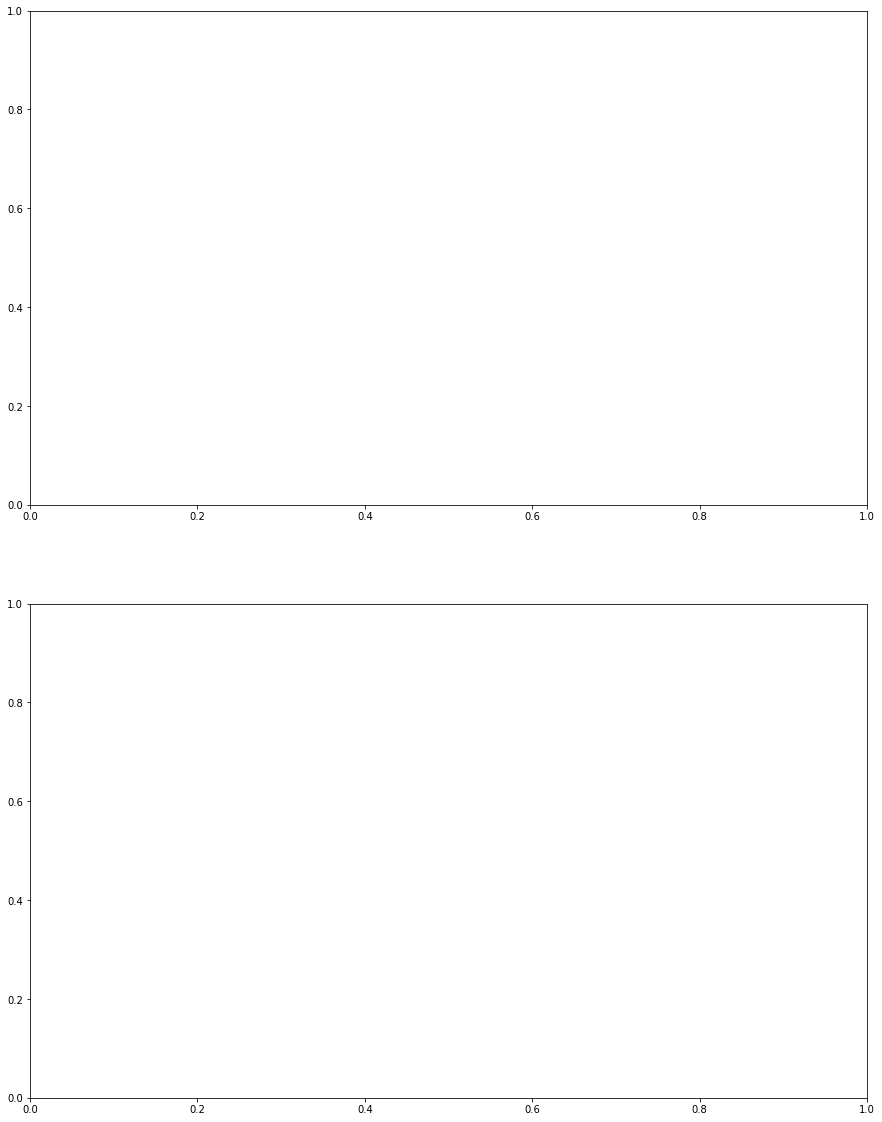

In [17]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 20))

for key, value in masks.items():
    difference_cogito = masks[key]['cogito_daily']['movingCountAdjusted'] - qa_daily['movingCountAdjusted']
    difference_qa = (masks[key]['cogito_daily']['movingCountAdjusted'] - qa_daily['movingCountAdjusted']) / qa_daily['movingCountAdjusted']
   
    key_cogito = '%s: %0.2f' % (key, np.mean(difference_cogito[~np.isnan(difference_cogito)]))
    key_qa = '%s: %0.0f%%' % (key, np.mean(np.abs(difference_qa[~np.isnan(difference_qa)]) * 100))
    
    c0 = masks[key]['cogito_daily_count']['movingCountAdjusted']
    c1 = cogito_daily_count['movingCountAdjusted']
    c2 = qa_daily_count['movingCountAdjusted']
    
    v0 = masks[key]['cogito_daily_sd']['movingCountAdjusted'] ** 2
    v1 = cogito_daily_sd['movingCountAdjusted'] ** 2
    v2 = qa_daily_sd['movingCountAdjusted'] ** 2
    
    t1 = np.abs(difference_cogito) / np.sqrt(v0 / c0 + v1 / c1)
    t2 = np.abs(difference_cogito) / np.sqrt(v0 / c0 + v2 / c2)
    
    z1 = np.median(t1[~np.isnan(t1)])
    z2 = np.median(t2[~np.isnan(t2)])
    z3 = np.mean(t1[~np.isnan(t1)])
    z4 = np.mean(t2[~np.isnan(t2)])
    
    p1 = 1 - stats.norm.cdf(z1)
    p2 = 1 - stats.norm.cdf(z2)
    p3 = 1 - stats.norm.cdf(z3)
    p4 = 1 - stats.norm.cdf(z4)
    
    #print('%0.2f %0.2f %0.2f %0.2f %s' % (z1, z2, z3, z4, key))
    print('%0.2f %0.2f %0.2f %0.2f %s' % (p1, p2, p3, p4, key))
    
    axes[0].bar(cogito_daily.index, difference_cogito, label = key_cogito)
    axes[1].bar(cogito_daily.index, difference_qa, label = key_qa)

for i in range(2):
    axes[i].axhline(0)
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Difference')
    axes[i].legend()
    
axes[0].set_title('Pen %i: Absolute Difference between QA Mobile Average' % (pen_id, ))
axes[1].set_title('Pen %i: Percent Difference between QA Mobile Average' % (pen_id, ))

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 20))

for key, value in masks.items():
    difference_cogito = masks[key]['cogito_daily']['adultFemaleCountAdjusted'] - qa_daily['adultFemaleCountAdjusted']
    difference_qa = (masks[key]['cogito_daily']['adultFemaleCountAdjusted'] - qa_daily['adultFemaleCountAdjusted']) / qa_daily['adultFemaleCountAdjusted']
   
    key_cogito = '%s: %0.2f' % (key, np.mean(difference_cogito[~np.isnan(difference_cogito)]))
    key_qa = '%s: %0.0f%%' % (key, np.mean(np.abs(difference_qa[~np.isnan(difference_qa)]) * 100))
    
    c0 = masks[key]['cogito_daily_count']['adultFemaleCountAdjusted']
    c1 = cogito_daily_count['adultFemaleCountAdjusted']
    c2 = qa_daily_count['adultFemaleCountAdjusted']
    
    v0 = masks[key]['cogito_daily_sd']['adultFemaleCountAdjusted'] ** 2
    v1 = cogito_daily_sd['adultFemaleCountAdjusted'] ** 2
    v2 = qa_daily_sd['adultFemaleCountAdjusted'] ** 2
    
    t1 = np.abs(difference_cogito) / np.sqrt(v0 / c0 + v1 / c1)
    t2 = np.abs(difference_cogito) / np.sqrt(v0 / c0 + v2 / c2)
    
    z1 = np.median(t1[~np.isnan(t1)])
    z2 = np.median(t2[~np.isnan(t2)])
    z3 = np.mean(t1[~np.isnan(t1)])
    z4 = np.mean(t2[~np.isnan(t2)])
    
    p1 = 1 - stats.norm.cdf(z1)
    p2 = 1 - stats.norm.cdf(z2)
    p3 = 1 - stats.norm.cdf(z3)
    p4 = 1 - stats.norm.cdf(z4)
    
    #print('%0.2f %0.2f %0.2f %0.2f %s' % (z1, z2, z3, z4, key))
    print('%0.2f %0.2f %0.2f %0.2f %s' % (p1, p2, p3, p4, key))
    
    axes[0].bar(cogito_daily.index, difference_cogito, label = key_cogito)
    axes[1].bar(cogito_daily.index, difference_qa, label = key_qa)

for i in range(2):
    axes[i].axhline(0)
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Difference')
    axes[i].legend()
    
axes[0].set_title('Pen %i: Absolute Difference between QA Adult Female Average Average' % (pen_id, ))
axes[1].set_title('Pen %i: Percent Difference between QA Adult Female Average Average' % (pen_id, ))

In [ ]:
# fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (15, 10))

# for key, value in masks.items():
#     axes.bar(cogito_daily.index, masks[key]['cogito_daily']['adultFemaleCountAdjusted'] - cogito_daily['adultFemaleCountAdjusted'], label = key)
#     print(key, np.mean(masks[key]['cogito_daily']['adultFemaleCountAdjusted'] - cogito_daily['adultFemaleCountAdjusted']))

# axes.axhline(0)
# axes.legend()

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (15, 10))

for key, value in masks.items():
    print(key)
    axes.bar(masks[key]['cogito_daily_count'].index, masks[key]['cogito_daily_count']['movingCountAdjusted'], label = key)
    
axes.legend()

In [18]:
for key, value in masks.items():
    plt.plot(masks[key]['qa_daily'])

KeyError: 'qa_daily'

In [19]:
plt.plot(cogito_daily['adultFemaleCountAdjusted'])
plt.plot(qa_daily['adultFemaleCountAdjusted'])

NameError: name 'cogito_daily' is not defined